In [2]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from pandarallel import pandarallel


/var/folders/rl/8r_3m_r94_j58zn6wmg4r9m80000gn/T/ipykernel_1661/3724013199.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [25]:
delitos = pd.read_csv('../Datasets/delitos_2022.csv')
robos_all_years = pd.read_csv('../Datasets/robos_all_years.csv')
comisarias = pd.read_csv('../Datasets/comisarias-policia-de-la-ciudad.csv')

In [3]:
robos_all_years.shape

(653525, 19)

In [4]:
robos_all_years.duplicated(subset=['latitud', 'longitud']).sum()

354093

In [5]:
comisarias.head()

,long,lat,id,nombre,calle,altura,calle2,direccion,telefonos,observaciones,observaciones_2,barrio,comuna,codigo_postal,codigo_postal_argentino
0,-58.373245,-34.601906,1,Comisaria Vecinal 1-D,Lavalle,451,NaN,LAVALLE 451,4322-8033/8221,NaN,NaN,SAN NICOLAS,1,1047.0,C1047AAI
1,-58.424926,-34.628641,37,Comisaria Vecinal 5-B,Muñiz,1250,NaN,MUÑIZ 1250,4922-1229 /4922-3333,NaN,NaN,BOEDO,5,1255.0,C1255ACD
2,-58.439501,-34.608979,39,Comisaria Vecinal 6-A,Diaz Velez,5152,NaN,DIAZ VELEZ AV. 5152,4982-4509/4520,NaN,NaN,CABALLITO,6,1405.0,C1405DCT
3,-58.448087,-34.626780,8,Comisaria Vecinal 7-B,Valle,1454,NaN,VALLE 1454,4432-3334/3922,"Ubicada en comuna 6, dependencia comuna 7",NaN,CABALLITO,6,1406.0,C1406GTH
4,-58.453221,-34.620382,38,Comisaria Comunal 6,Avellaneda,1548,NaN,AVELLANEDA AV. 1548,4632-9051/9129,NaN,NaN,CABALLITO,6,1406.0,C1406FYN


In [6]:
robos_all_years

,id-mapa,anio,mes,dia,fecha,franja,tipo,subtipo,uso_arma,uso_moto,barrio,comuna,latitud,longitud,cantidad,mes_numero,dia_numero,dia_mes_numero,anio_mes
0,252569,2019,ENERO,LUNES,2019-01-28,8.0,Hurto,Hurto total,NO,NO,PARQUE PATRICIOS,4.0,-34.630835,-58.391528,1,1,1,28,2019-01
1,252570,2019,MARZO,LUNES,2019-03-04,11.0,Hurto,Hurto total,NO,NO,PARQUE PATRICIOS,4.0,-34.628442,-58.391876,1,3,1,4,2019-03
2,252571,2019,ABRIL,MIERCOLES,2019-04-10,18.0,Robo,Robo total,NO,NO,PARQUE PATRICIOS,4.0,-34.630313,-58.391512,1,4,3,10,2019-04
3,252572,2019,NOVIEMBRE,LUNES,2019-11-18,12.0,Hurto,Hurto total,NO,NO,PARQUE PATRICIOS,4.0,-34.630163,-58.391542,1,11,1,18,2019-11
4,252573,2019,ABRIL,LUNES,2019-04-01,17.0,Robo,Robo total,NO,NO,PARQUE PATRICIOS,4.0,-34.629944,-58.391882,1,4,1,1,2019-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653520,831327,2017,DICIEMBRE,DOMINGO,2017-12-31,23.0,Hurto,Hurto total,NO,NO,VILLA URQUIZA,12.0,-34.569537,-58.488005,1,12,7,31,2017-12
653521,831330,2017,DICIEMBRE,DOMINGO,2017-12-31,14.0,Hurto,Hurto total,NO,NO,BELGRANO,13.0,-34.559850,-58.452968,1,12,7,31,2017-12
653522,831333,2017,DICIEMBRE,DOMINGO,2017-12-31,0.0,Hurto,Hurto total,NO,NO,NUÑEZ,13.0,-34.552862,-58.462993,1,12,7,31,2017-12
653523,831336,2017,DICIEMBRE,DOMINGO,2017-12-31,9.0,Hurto,Hurto total,NO,NO,VILLA PUEYRREDON,12.0,-34.572164,-58.505348,1,12,7,31,2017-12


In [12]:
pandarallel.initialize()

def calcular_distancia(row, df2):
    lat_df1, lon_df1 = row['latitud'], row['longitud']
    distances = df2.apply(lambda x: geodesic((lat_df1, lon_df1), (x['lat'], x['long'])).meters, axis=1)
    min_distance_idx = distances.idxmin()
    min_distance = distances[min_distance_idx]
    id_comisaria_cercana = df2.loc[min_distance_idx, 'id']
    return pd.Series({'distancia': min_distance, 'id_comisaria': id_comisaria_cercana})

def calcular_distancias_cercanas(df1, df2):
    resultados_df = df1.parallel_apply(calcular_distancia, df2=df2, axis=1)
    resultados_df.insert(0, 'id_delito', df1['id-mapa'])
    return resultados_df


distancia_entre_delitos_y_comisaria = calcular_distancias_cercanas(robos_all_years, comisarias)
distancia_entre_delitos_y_comisaria.to_csv('../Datasets/distancia_entre_delito_y_comisaria.csv', index=False)
distancia_entre_delitos_y_comisaria


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,id_delito,distancia,id_comisaria
0,252569,917.794982,42.0
1,252570,657.718990,42.0
2,252571,859.954510,42.0
3,252572,843.603533,42.0
4,252573,822.756662,42.0
...,...,...,...
653520,831327,700.162806,26.0
653521,831330,306.117267,17.0
653522,831333,167.747169,18.0
653523,831336,1578.768606,49.0


In [10]:
distancia_entre_delitos_y_comisaria = pd.read_csv('../Datasets/distancia_entre_delito_y_comisaria.csv')

# Definir los límites de los intervalos
bins = [-np.inf, 100, 300, 500, 1000, np.inf]

# Definir los nombres de las etiquetas para cada intervalo
labels = ['<100', '100-300', '301-500', '501-1000', '>1000']


# Renombr columnas

distancia_entre_delitos_y_comisaria.rename(columns={'distancia':'distancia_a_comisaria_m'}, inplace=True)
distancia_entre_delitos_y_comisaria['distancia_a_comisaria_m'] = distancia_entre_delitos_y_comisaria['distancia_a_comisaria_m'].round(0)

distancia_entre_delitos_y_comisaria['distancia_a_comisaria_m'] = distancia_entre_delitos_y_comisaria['distancia_a_comisaria_m'].astype('int32')
distancia_entre_delitos_y_comisaria['id_comisaria'] = distancia_entre_delitos_y_comisaria['id_comisaria'].astype('int32')

# Crear la columna categórica usando pd.cut()
distancia_entre_delitos_y_comisaria['distancia_a_comisaria_grupo'] = pd.cut(distancia_entre_delitos_y_comisaria['distancia_a_comisaria_m'], 
                                                                    bins = bins, 
                                                                    labels = labels, 
                                                                    right = False)



distancia_entre_delitos_y_comisaria.to_csv('../Datasets/distancia_entre_delito_y_comisaria_clean.csv', index=False)


In [11]:
distancia_entre_delitos_y_comisaria


,id_delito,distancia_a_comisaria_m,id_comisaria,distancia_a_comisaria_grupo
0,252569,918,42,501-1000
1,252570,658,42,501-1000
2,252571,860,42,501-1000
3,252572,844,42,501-1000
4,252573,823,42,501-1000
...,...,...,...,...
653520,831327,700,26,501-1000
653521,831330,306,17,301-500
653522,831333,168,18,100-300
653523,831336,1579,49,>1000


<Axes: >

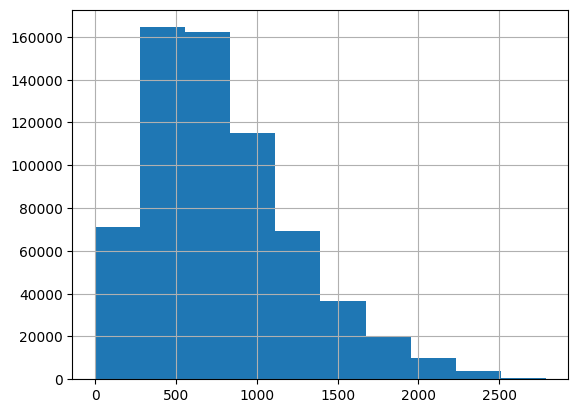

In [8]:
distancia_entre_delitos_y_comisaria.distancia.hist()

<Axes: >

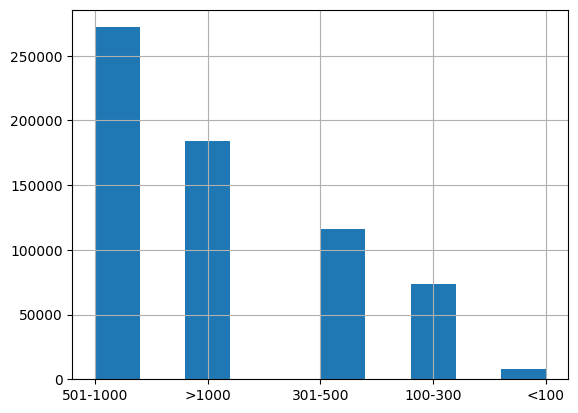

In [9]:
distancia_entre_delitos_y_comisaria.distancia_categoria.hist()

In [10]:
distancia_entre_delitos_y_comisaria.sort_values('distancia', ascending=True)

,id_delito,distancia,id_comisaria,distancia_categoria
214254,198933,0.0,57.0,<100
138977,602546,0.0,11.0,<100
202720,819664,0.0,1.0,<100
26667,280744,0.0,10.0,<100
152458,644198,0.0,7.0,<100
...,...,...,...,...
388930,49565,2786.0,52.0,>1000
9488,263010,2786.0,52.0,>1000
359471,19105,2789.0,53.0,>1000
420420,82817,2789.0,53.0,>1000


In [14]:
(distancia_entre_delitos_y_comisaria['distancia_categoria'] == '<100').sum()

7999

In [36]:

### BACKUP CODE ###

def calcular_distancias_cercanas(df1, df2):
    resultados = []

    # Pre-cálculo de las distancias
    distancias = {}
    for index2, row_df2 in df2.iterrows():
        lat_df2, lon_df2, id_df2 = row_df2['lat'], row_df2['long'], row_df2['id']
        distancias[id_df2] = (lat_df2, lon_df2)

    for index1, row_df1 in df1.iterrows():
        lat_df1, lon_df1, id_df1 = row_df1['latitud'], row_df1['longitud'], row_df1['id-mapa']
        
        min_distancia = float('inf')
        id_comisaria_cercana = None
        
        for id_comisaria, (lat_df2, lon_df2) in distancias.items():
            distancia = geodesic((lat_df1, lon_df1), (lat_df2, lon_df2)).meters
            if distancia < min_distancia:
                min_distancia = distancia
                id_comisaria_cercana = id_comisaria

        resultados.append({'id_delito': id_df1, 'distancia': min_distancia, 'id_comisaria': id_comisaria_cercana})
        #print(index1)

    resultados_df = pd.DataFrame(resultados)
    return resultados_df

distancia_entre_delitos_y_comisaria = calcular_distancias_cercanas(robos_all_years.head(100), comisarias)


In [27]:
comisarias

,long,lat,id,nombre,calle,altura,calle2,direccion,telefonos,observaciones,observaciones_2,barrio,comuna,codigo_postal,codigo_postal_argentino
0,-58.373245,-34.601906,1,Comisaria Vecinal 1-D,Lavalle,451,NaN,LAVALLE 451,4322-8033/8221,NaN,NaN,SAN NICOLAS,1,1047.0,C1047AAI
1,-58.424926,-34.628641,37,Comisaria Vecinal 5-B,Muñiz,1250,NaN,MUÑIZ 1250,4922-1229 /4922-3333,NaN,NaN,BOEDO,5,1255.0,C1255ACD
2,-58.439501,-34.608979,39,Comisaria Vecinal 6-A,Diaz Velez,5152,NaN,DIAZ VELEZ AV. 5152,4982-4509/4520,NaN,NaN,CABALLITO,6,1405.0,C1405DCT
3,-58.448087,-34.626780,8,Comisaria Vecinal 7-B,Valle,1454,NaN,VALLE 1454,4432-3334/3922,"Ubicada en comuna 6, dependencia comuna 7",NaN,CABALLITO,6,1406.0,C1406GTH
4,-58.453221,-34.620382,38,Comisaria Comunal 6,Avellaneda,1548,NaN,AVELLANEDA AV. 1548,4632-9051/9129,NaN,NaN,CABALLITO,6,1406.0,C1406FYN
5,-58.380178,-34.594643,10,Comisaria Comunal 1,Suipacha,1156,NaN,SUIPACHA 1156,4393-0076/3333/7058,NaN,NaN,RETIRO,1,1008.0,C1008AAX
6,-58.385608,-34.622670,43,Comisaria Vecinal 1-C (edificio anexo),San Jose,1224,NaN,SAN JOSE 1224,4306-3333/4067,NaN,NaN,CONSTITUCION,1,1136.0,C1136AAB
7,-58.392359,-34.591137,11,Comisaria Comunal 2,Las Heras Gral.,1861,NaN,LAS HERAS GENERAL AV. 1861,4801-1698/3333,NaN,NaN,RECOLETA,2,1127.0,C1127AAA
8,-58.390749,-34.622587,42,Comisaria Vecinal 1-C,Av. San Juan,1757,NaN,SAN JUAN AV. 1757,4304-3203/4300 /4305-3333,NaN,NaN,CONSTITUCION,1,1148.0,C1148AAF
9,-58.406719,-34.594079,29,Comisaria Vecinal 2-B,Charcas,2844,NaN,CHARCAS 2844,4822-3333/6311,NaN,NaN,RECOLETA,2,1425.0,C1425BMH


In [29]:
comisarias['id']

0      1
1     37
2     39
3      8
4     38
5     10
6     43
7     11
8     42
9     29
10     2
11    41
12    34
13    40
14    12
15    13
16    45
17     3
18    15
19    32
20    17
21    47
22    18
23    19
24    33
25    48
26    49
27     4
28    20
29    21
30    22
31    23
32    50
33    27
34    24
35    25
36    26
37     5
38    51
39    52
40    44
41    53
42    54
43     6
44    35
45     7
46    56
47    57
48    55
Name: id, dtype: int64

In [35]:
# código para validar las distancias

id_delito = 19105
id_comisaria = 2


delito_i =(robos_all_years[robos_all_years['id-mapa'] == id_delito]['latitud'].iloc[0], 
           robos_all_years[robos_all_years['id-mapa'] == id_delito]['longitud'].iloc[0])


comisaria_i =(comisarias[comisarias['id'] == id_comisaria]['lat'].iloc[0],
               comisarias[comisarias['id'] == id_comisaria]['long'].iloc[0])

min_distancia = float('inf')
for id_comisaria in comisarias['id']:
    comisaria_i =(comisarias[comisarias['id'] == id_comisaria]['lat'].iloc[0],
               comisarias[comisarias['id'] == id_comisaria]['long'].iloc[0])
    distancia = geodesic((delito_i), (comisaria_i)).meters
    if distancia < min_distancia:
        min_distancia = distancia
        print(min_distancia)

6276.359289672356
5250.825720446756
4338.78122810816
4254.744328535313
3513.0939279263685
3018.58741380415
2814.2073455060313
2788.885768118369


In [ ]:
delitos[delitos['id-mapa'] == 102]